In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load data

In [3]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [4]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [5]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

In [71]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [72]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  



We are testing the optimization method on fold  0


In [73]:
# Define hyperparameters

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seed = 42
torch.manual_seed(seed)

seq_length = 75

#Hyperparameters objective and regularization
alpha_reg = 1.21e-6
l1_ratio_reg = 0.394

lr = 0.00193
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 10
num_layers = 1
#input_size = 31 Not for now, only if I need a linear layer before the RNN

#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

Reg = globals().get(reg_hnet)

**RNN Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional RNN. Default: False

In [74]:
#model = CausalRNN(input_size= num_features, hidden_size = hidden_units, num_layers= num_layers, output_dim=num_dim_output, dropout= 0.3)

In [77]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 10
input_rec = 40
seq_length_LSTM = 10

model = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = False).to(device) 
#Here we use no_weights = False to try to train the model only on baseline data

Creating a simple RNN with 5783 weights.


In [78]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.1201 Val 0.0465
Epoch 001 Train 0.0164 Val 0.0312
Epoch 002 Train 0.0077 Val 0.0260
Epoch 003 Train 0.0053 Val 0.0212
Epoch 004 Train 0.0038 Val 0.0209
Epoch 005 Train 0.0028 Val 0.0216
Epoch 006 Train 0.0022 Val 0.0220
Epoch 007 Train 0.0017 Val 0.0204
Epoch 008 Train 0.0014 Val 0.0227
Epoch 009 Train 0.0012 Val 0.0218
Epoch 010 Train 0.0010 Val 0.0220
Epoch 011 Train 0.0009 Val 0.0228
Epoch 012 Train 0.0007 Val 0.0225
Epoch 013 Train 0.0005 Val 0.0237
Epoch 014 Train 0.0005 Val 0.0231
Decrease LR
Epoch 015 Train 0.0004 Val 0.0229
Epoch 016 Train 0.0003 Val 0.0232
Epoch 017 Train 0.0003 Val 0.0233
Epoch 018 Train 0.0002 Val 0.0235
Epoch 019 Train 0.0002 Val 0.0235
Decrease LR


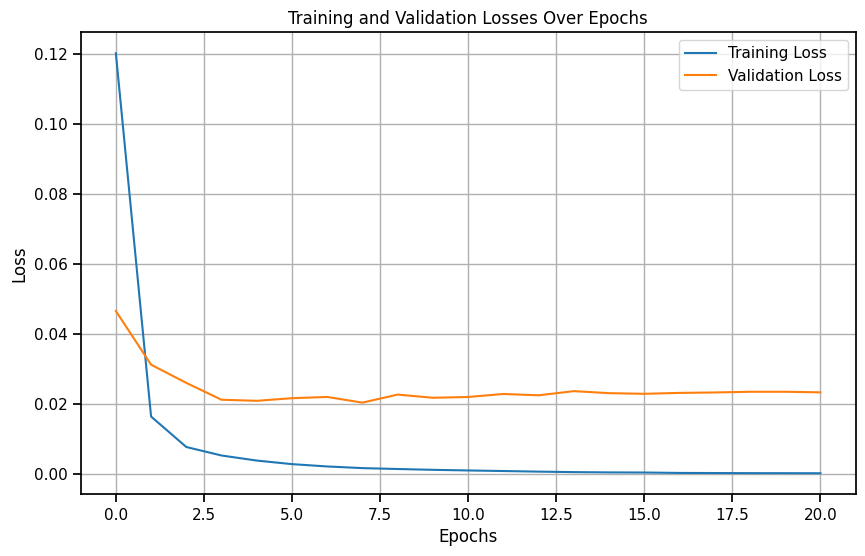

In [79]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [80]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.89 
Val EV: 0.46 
Test EV: 0.32 


## CL with Hypernetworks

First we define the BASELINE and STIMULATION datasets for CL.

In [6]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [7]:
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [8]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


Tutorial on the use of the hypnettorch package: https://github.com/chrhenning/hypnettorch/blob/master/hypnettorch/tutorials/getting_started.ipynb


From hypnettorch, we have:

- `SimpleRNN:` model which works as main networks and which has already the option or passing weights generated by other network in the forward loop.
    
- `HMLP:` A variety of hypernetworks is available in subpackage hypnettorch.hnets. The simplest being a fully-connected hypernetwork, see class hypnettorch.hnets.HMLP. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, hypnettorch.hnets.ChunkedHMLP). However, to keep this tutorial light, we don't discuss these options here.

In [9]:
from IPython.display import display, Markdown, Latex

In [10]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[2]
num_features = x_train_stim.shape[2]

seed = 42
torch.manual_seed(seed)

seq_length = 75

In [11]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 10
input_rec = 40
seq_length_LSTM = 10


model = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = True).to(device) 
# Here no_weight set to true for the model to take the weights generated with the hypernetwork

Creating a simple RNN with 7233 weights.


Hypernetworks usually distinguish between two types of inputs: *conditional* and *unconditional* inputs. Conditional inputs are simply inputs that can be related to a finite and discrete set of conditions, such as the [task identity in continual learning](https://arxiv.org/abs/1906.00695). Simply speaking, conditional inputs can be used if the number $N$ of conditions is known a priori. In this case, the hypernetwork will create a set of $N$ learnable condition vectors (e.g., task embeddings), and can take the condition ID (as integer) as input to the ``forward`` method. This simplifies many usage scenarios, as the user of a hypernetwork does not have to maintain learnable input embeddings to the hypernetwork by himself. In all other cases (like the input to the hypernetwork comes from a continuous vector space), *unconditional* inputs should be used.

In our case, the hypernetwork should either generate a set of weights for MNIST (condition $0$) or FashionMNIST (condition $1$). Each of these conditions should internally be represented by a $8$-dimensional embedding vector.

In [12]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(model.param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[20, 20], 
            num_cond_embs=num_conditions).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 152509 weights and 7233 outputs (compression ratio: 21.09).
The network consists of 152493 unconditional weights (152493 internally maintained) and 16 conditional weights (16 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380],
       requires_grad=True), Parameter containing:
tensor([ 0.4617,  0.2674,  0.5349,  0.8094,  1.1103, -1.6898, -0.9890,  0.9580],
       requires_grad=True)]


**Hypernetwork initialization** 
can be an important factor, for instance, [when using optimizers such as SGD](https://openreview.net/forum?id=H1lma24tPB). 

Therefore, some hypernet implementations provide custom initialization functions.

In [13]:
hnet.apply_hyperfan_init(mnet=model)

**Making predictions** with the target network is fairly easy. Simply generate the corresponding weights with the hypernetwork and pass them to the ``forward`` method of the main network together with the network inputs. 

In [14]:
from torch.utils.data import Dataset

In [15]:
# Define parameters for training
num_epochs = 50
batch_size_train = 25
batch_size_val = 25
Reg = globals().get(reg_hnet)

In [16]:
train_losses, val_losses, W_base, W_stim = train_hypernet(model, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                regularizer = Reg)

Epoch 000 Train 0.8824 Val 0.4752
Epoch 001 Train 0.2778 Val 0.1227
Epoch 002 Train 0.0672 Val 0.0734
Epoch 003 Train 0.0387 Val 0.0635
Epoch 004 Train 0.0326 Val 0.0618
Epoch 005 Train 0.0276 Val 0.0591
Epoch 006 Train 0.0240 Val 0.0570
Epoch 007 Train 0.0222 Val 0.0537
Epoch 008 Train 0.0205 Val 0.0559
Epoch 009 Train 0.0181 Val 0.0547
Epoch 010 Train 0.0173 Val 0.0535
Epoch 011 Train 0.0156 Val 0.0526
Epoch 012 Train 0.0146 Val 0.0547
Epoch 013 Train 0.0135 Val 0.0538
Epoch 014 Train 0.0126 Val 0.0548
Epoch 015 Train 0.0115 Val 0.0542
Decrease LR
Epoch 016 Train 0.0111 Val 0.0531
Epoch 017 Train 0.0103 Val 0.0542
Epoch 018 Train 0.0102 Val 0.0541
Epoch 019 Train 0.0096 Val 0.0506
Epoch 020 Train 0.0091 Val 0.0519
Epoch 021 Train 0.0086 Val 0.0500
Epoch 022 Train 0.0086 Val 0.0533
Epoch 023 Train 0.0082 Val 0.0514
Epoch 024 Train 0.0079 Val 0.0510
Epoch 025 Train 0.0077 Val 0.0519
Decrease LR


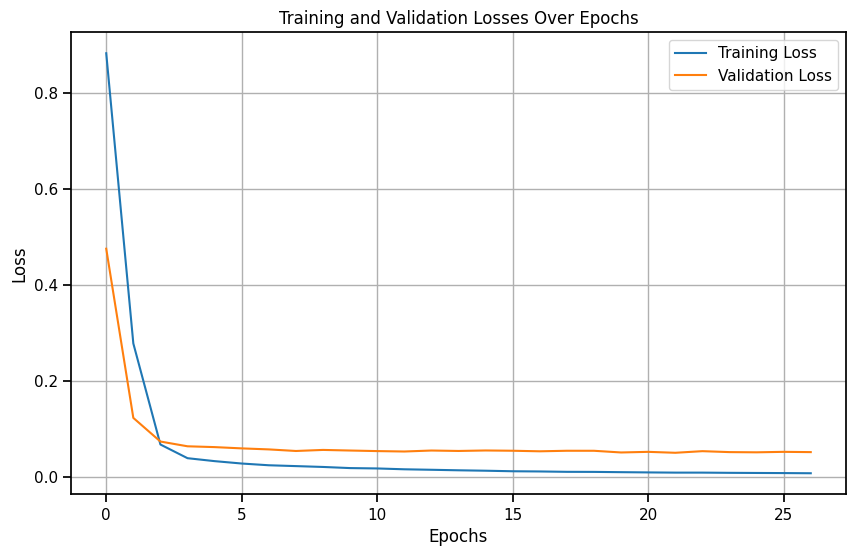

In [17]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [18]:
def reshape_to_eval(x,y, model):
    to_t_eval =  lambda array: torch.tensor(array, device='cpu', dtype=dtype)  
    x = to_t_eval(x) 
    y = to_t_eval(y)
    y_pred = model(x)
    y_array = y.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D

In [19]:
def calc_explained_variance(x, y, mnet, mnet_weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        # Forward pass to get predictions
        predictions = mnet(inputs, weights=mnet_weights)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        explained_var = explained_variance_score(y_true_2D, y_pred_2D)

    return explained_var

In [20]:
calc_explained_variance(x_train_base, y_train_base, model, W_base)

0.7093563874562582